# Transcripts

In [5]:
import pandas as pd

at = pd.read_csv('./data/npi/transcripts/all_transcripts.csv').dropna(subset='q_a')[['index','q_a']].rename(columns={'index':'org_idx'})
t_ref = pd.read_csv('./data/npi/transcripts/t_reference.csv')[['filename']]

In [6]:
at

,org_idx,q_a
0,0,QUESTION:\nSIR BRIAN LANGSTAFF:ANSWER:\nA.
1,0,QUESTION:\nQ.ANSWER:\nA.
2,0,"QUESTION:\n Mrs D, on 19 May 1986 you went int..."
3,0,QUESTION:\n You were admitted into hospital?\n...
4,0,QUESTION:\n And on 23 May you were told you ha...
...,...,...
53851,399,"QUESTION:\n Just so everybody is aware, JPAC..."
53852,399,"QUESTION:\n Dr Cave, if I could ask the same..."
53853,399,QUESTION:\n I turn to those who are represen...
53854,399,"QUESTION:\n Dr Cave, if I could turn to you,..."


In [7]:
t_ref

,filename
0,2019-05-10 TS_Mrs D [W1921].pdf
1,2019-05-06 TS_Michelle Baker [W1825].pdf
2,2020-02-25 TS_Psychosocial Experts (London).pdf
3,2019-05-01 TS_Carolyn Challis [W0622].pdf
4,2019-05-01 TS_Kate Ashton [W1416].pdf
...,...
398,2022-11-15 TS_Dr Susan Hopkins and Professor C...
399,"2022-11-16 TS_Professor James Neuberger, Profe..."
400,2023-01-17 TS_Oral Submissions Collins & Andre...
401,2023-01-17 TS_Steven Snowden KC & Andrew Bragg...


In [8]:
at['filename'] = at['org_idx'].apply(lambda x: t_ref.loc[x].filename)

In [9]:
from datetime import datetime
at['date'] =  at['filename'].apply(lambda x: datetime.strptime(x.split(' ')[0], '%Y-%m-%d'))

In [21]:
from whoosh.fields import Schema, TEXT, DATETIME
from whoosh.analysis import StandardAnalyzer

schema = Schema(filename=TEXT(stored=True, sortable=True), title=TEXT(stored=True, sortable=True), date=DATETIME(stored=True, sortable=True), text=TEXT(stored=True, analyzer=StandardAnalyzer(stoplist=None)), full_text=TEXT(stored=True, analyzer=StandardAnalyzer(stoplist=None)))

In [22]:
import re
at['answers'] = at['q_a'].apply(lambda x: re.split('ANSWER:', x)[-1])

In [23]:
at

,org_idx,q_a,filename,date,answers
0,0,QUESTION:\nSIR BRIAN LANGSTAFF:ANSWER:\nA.,2019-05-10 TS_Mrs D [W1921].pdf,2019-05-10,\nA.
1,0,QUESTION:\nQ.ANSWER:\nA.,2019-05-10 TS_Mrs D [W1921].pdf,2019-05-10,\nA.
2,0,"QUESTION:\n Mrs D, on 19 May 1986 you went int...",2019-05-10 TS_Mrs D [W1921].pdf,2019-05-10,"\n I did, yes.\n"
3,0,QUESTION:\n You were admitted into hospital?\n...,2019-05-10 TS_Mrs D [W1921].pdf,2019-05-10,\n Yes.\n
4,0,QUESTION:\n And on 23 May you were told you ha...,2019-05-10 TS_Mrs D [W1921].pdf,2019-05-10,"\n That's right, yes.\n"
...,...,...,...,...,...
53851,399,"QUESTION:\n Just so everybody is aware, JPAC...","2022-11-16 TS_Professor James Neuberger, Profe...",2022-11-16,"\n Yes, it's a group of -- variety of blood\..."
53852,399,"QUESTION:\n Dr Cave, if I could ask the same...","2022-11-16 TS_Professor James Neuberger, Profe...",2022-11-16,"\n No, our role is to implement the recommen..."
53853,399,QUESTION:\n I turn to those who are represen...,"2022-11-16 TS_Professor James Neuberger, Profe...",2022-11-16,"\n Much to my, I don't know, surprise or\nho..."
53854,399,"QUESTION:\n Dr Cave, if I could turn to you,...","2022-11-16 TS_Professor James Neuberger, Profe...",2022-11-16,"\n Other than echoing those comments, I woul..."


In [25]:
import os.path
from whoosh.index import create_in

if not os.path.exists("indices/transcript_answers_index"):
    os.mkdir("indices/transcript_answers_index")
ix = create_in("indices/transcript_answers_index", schema)

In [26]:
from whoosh.index import open_dir

ix = open_dir("indices/transcript_answers_index")

In [27]:
writer = ix.writer()
for i in range(len(at)):
    writer.add_document(
        filename = at.iloc[i].filename,
        title = ' '.join(at.iloc[i].filename.split(' ')[1:]),
        text = at.iloc[i].answers,
        full_text = at.iloc[i].q_a,
        date = at.iloc[i].date.to_pydatetime() # need to_pydatetime
    )
writer.commit()

In [28]:
from whoosh.qparser import QueryParser
query_str = 'AIDs'
parser = QueryParser("text", ix.schema)
query = parser.parse(query_str)

with ix.searcher() as searcher:
    results = searcher.search(query)
    print(results[0])

<Hit {'date': datetime.datetime(2019, 11, 1, 0, 0), 'filename': '2019-11-01 TS_Mary Grindley [W2336] only.pdf', 'full_text': "QUESTION:\n So we can see the date that it was was November 1 983, \nand your understanding, yours and John's, was this some \nform of AIDS reaction test.\nANSWER:\n Yes.  In his notes it doesn't say AIDS, but that -- we \ncalled it an AIDS test.26 \n", 'text': "\n Yes.  In his notes it doesn't say AIDS, but that -- we \ncalled it an AIDS test.26 \n", 'title': 'TS_Mary Grindley [W2336] only.pdf'}>


# Written Statements

In [2]:
import pandas as pd
aw = pd.read_csv('./data/npi/written_statements/all_written_statements.csv').dropna(subset='answers')[['index','answers']].rename(columns={'index':'org_idx'}).reset_index(drop=True)
w_ref = pd.read_csv('./data/npi/written_statements/ws_reference.csv')[['fname']]

In [3]:
w_ref

,fname
0,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt
1,2022-10-07 WITN7503001 WS-R_Tracey Carter (obo...
2,2020-04-24 W0797001 WS_[W0797].txt
3,2022-03-16 WITN6932013 WS-R_Professor Ludlam i...
4,2019-06-14 WITN1413002 WS_Stephen John Morrow.txt
...,...
3399,2019-11-12 WITN3849001 WS_[W3849] - 12 Nov 201...
3400,2022-08-12 WITN5610001 WS_Peter Michael Hughes...
3401,2002-09-29 WITN7152001 WS-1_Simon Tonkin - 29 ...
3402,2022-06-22 WITN7108001 WS_Ian Slaymaker - 22 J...


In [4]:
aw['filename'] = aw['org_idx'].apply(lambda x: w_ref.loc[x].fname)

In [5]:
aw

,org_idx,answers,filename
0,0,iirn;iria \n• • $ R \nI provide this statement...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt
1,0,MFT had originally been set up by the Secreta...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt
2,0,MFT did lobby DHSC for additional funding for...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt
3,0,MFT did not undertake fundraising during my t...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt
4,0,Due to the passage of time I cannot recall th...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt
...,...,...,...
80973,3403,I.knew that i.GRoB]had suffered a bad acciden...,2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...
80974,3403,"GROBl,was taken to GROB ;(which no longer exi...",2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...
80975,3403,"Other Infections \n.As far as I am aware,GROB...",2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...
80976,3403,"5cm and one \nthat was 3cm, and I was able to ...",2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...


In [7]:
from datetime import datetime
def parse_date_no_none(filename):
    date_str = filename.split(' ')[0]
    if date_str != 'None':
        return datetime.strptime(date_str, '%Y-%m-%d')

aw['date'] =  aw['filename'].apply(parse_date_no_none)

In [8]:
aw

,org_idx,answers,filename,date
0,0,iirn;iria \n• • $ R \nI provide this statement...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
1,0,MFT had originally been set up by the Secreta...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
2,0,MFT did lobby DHSC for additional funding for...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
3,0,MFT did not undertake fundraising during my t...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
4,0,Due to the passage of time I cannot recall th...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
...,...,...,...,...
80973,3403,I.knew that i.GRoB]had suffered a bad acciden...,2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20
80974,3403,"GROBl,was taken to GROB ;(which no longer exi...",2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20
80975,3403,"Other Infections \n.As far as I am aware,GROB...",2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20
80976,3403,"5cm and one \nthat was 3cm, and I was able to ...",2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20


In [10]:
import nltk
sent_tokenized = aw.answers.apply(lambda x: nltk.sent_tokenize(x))

<Axes: >

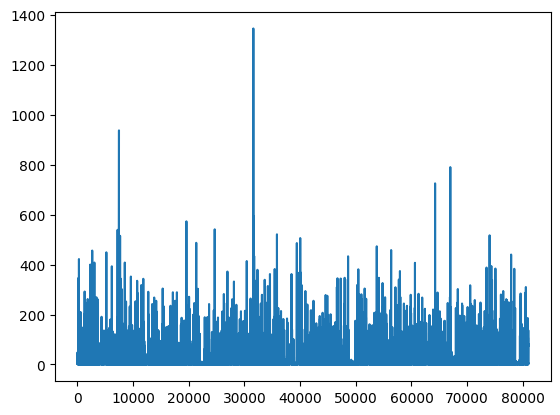

In [13]:
sent_tokenized.apply(lambda x: len(x)).plot()

In [14]:
sent_tokenized.apply(lambda x: len(x)).mean()

9.307688507989825

In [15]:
sent_tokenized.apply(lambda x: len(x)).std()

26.161554927248766

In [27]:
def combine_sentences(sent_list):
    return [' '.join(sent_list)]

def split_into_chunks(sent_list, chunk_size=10):
    chunks = [sent_list[i:i+chunk_size] for i in range(0, len(sent_list), chunk_size)]
    return [' '.join(chunk) for chunk in chunks]

In [34]:
chunked = sent_tokenized.apply(lambda x: combine_sentences(x) if len(x) <= 10 else split_into_chunks(x)).explode()

In [35]:
chunked = chunked.reset_index().rename(columns={'index':'df_org_index'})
chunked

,df_org_index,answers
0,0,iirn;iria \n• • $ R \nI provide this statement...
1,1,MFT had originally been set up by the Secreta...
2,2,MFT did lobby DHSC for additional funding for...
3,3,MFT did not undertake fundraising during my t...
4,4,Due to the passage of time I cannot recall th...
...,...,...
129704,80977,. If I GROB had been offered more psychologica...
129705,80977,"GROBrand I were shocked by this rejection, as ..."
129706,80977,GRO Bwould have also been sent away if they co...
129707,80977,. It felt like they were trying to block !GROB...


In [37]:
chunked['filename'] = chunked['df_org_index'].apply(lambda x: aw.iloc[x].filename)
chunked['date'] = chunked['df_org_index'].apply(lambda x: aw.iloc[x].date)

In [52]:
chunked.to_csv("./data/all_written_statements.csv")

In [38]:
chunked

,df_org_index,answers,filename,date
0,0,iirn;iria \n• • $ R \nI provide this statement...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
1,1,MFT had originally been set up by the Secreta...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
2,2,MFT did lobby DHSC for additional funding for...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
3,3,MFT did not undertake fundraising during my t...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
4,4,Due to the passage of time I cannot recall th...,2021-02-18 WITN3108010 WS-3_Jan Barlow.txt,2021-02-18
...,...,...,...,...
129704,80977,. If I GROB had been offered more psychologica...,2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20
129705,80977,"GROBrand I were shocked by this rejection, as ...",2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20
129706,80977,GRO Bwould have also been sent away if they co...,2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20
129707,80977,. It felt like they were trying to block !GROB...,2021-06-20 WITN5050001 WS_[W5050] - 20 Jun 202...,2021-06-20


In [41]:
from whoosh.fields import Schema, TEXT, DATETIME
from whoosh.analysis import StandardAnalyzer

schema = Schema(filename=TEXT(stored=True, sortable=True), title=TEXT(stored=True, sortable=True), date=DATETIME(stored=True, sortable=True), text=TEXT(stored=True, analyzer=StandardAnalyzer(stoplist=None)), full_text=TEXT(stored=True, analyzer=StandardAnalyzer(stoplist=None)))

In [42]:
from whoosh.index import create_in
if not os.path.exists("indices/written_statement_index"):
    os.mkdir("indices/written_statement_index")
ix = create_in("indices/written_statement_index", schema)

In [43]:
writer = ix.writer()
for i in range(len(chunked)):
    writer.add_document(
        filename = chunked.iloc[i].filename,
        title = ' '.join(chunked.iloc[i].filename.split(' ')[1:]),
        text = chunked.iloc[i].answers,
        date = chunked.iloc[i].date.to_pydatetime() if not isinstance(chunked.iloc[i].date, type(pd.NaT)) else None # need to_pydatetime
    )
writer.commit()

In [51]:
from whoosh.qparser import QueryParser
query_str = 'public auction'
parser = QueryParser("text", ix.schema)
query = parser.parse(query_str)

with ix.searcher() as searcher:
    results = searcher.search(query)
    print(results[0])

<Hit {'date': datetime.datetime(2022, 6, 9, 0, 0), 'filename': '2022-06-09 WITN5289001 WS-R_Baroness Virginia Bottomley; 09 Jun 2022.txt', 'text': 'Mr Heppell outlined the \nfollowing initial assessment of the scheme of compromise: \n"The proposals as they stand look on the high side especially as the \nplaintiffs\' counsel are looking for high legal costs and disregard of all \npayments for social security purposes. But the most important missing \nlink, as Mr Dobson says is the involvement of the plaintiffs themselves. We do not want to get down to discussion of detail until we can be \nconfident the plaintiffs are ready to settle on something like the basis \nproposed. Otherwise we would be at clear risk of being bid up in a public \nauction." 4 Mr Heppell noted that full advice would follow as soon as possible. Neither Mr \nDobson\'s minute nor Mr Heppell\'s appear to have been copied to my Private \nOffice. 4 On  November  Mr Canavan wrote to Mr Dobson and Mr Waldegrave\'s \nPriva

# National Archive 

In [231]:
na = pd.read_csv('./data/national_archives/nat_archive_files.csv').reset_index(drop=True)[['filename', 'sentences']]
na

,filename,sentences
0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,2 References\nPinukz Ms Wilkinson PS / Perm Se...
1,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,0Opm on Tuesday 15 December at Lancaster House...
2,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,55 _ Delegates will be greeted individually as...
3,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope that all attending will find the symposiu...
4,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope it will also give an opportunity for Cent...
...,...,...
152933,Litigation and Compensation/Litigation and Com...,"users, to produce information leaflets that co..."
152934,Litigation and Compensation/Litigation and Com...,298858 very they they way TEL:\n(478 PRiMARY C...
152935,Litigation and Compensation/Litigation and Com...,"Primary Care Directorate; Ditton Ward, Preston..."
152936,Litigation and Compensation/Litigation and Com...,48 of men reporting injecting in the last five...


In [232]:
na['raw_fname'] = na['filename'].apply(lambda x: '_'.join(x.split('/')[1].split('_')[1:]).replace('.txt',''))

In [233]:
na

,filename,sentences,raw_fname
0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,2 References\nPinukz Ms Wilkinson PS / Perm Se...,JA 418-CHL-Z-1.pdf
1,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,0Opm on Tuesday 15 December at Lancaster House...,JA 418-CHL-Z-1.pdf
2,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,55 _ Delegates will be greeted individually as...,JA 418-CHL-Z-1.pdf
3,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope that all attending will find the symposiu...,JA 418-CHL-Z-1.pdf
4,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope it will also give an opportunity for Cent...,JA 418-CHL-Z-1.pdf
...,...,...,...
152933,Litigation and Compensation/Litigation and Com...,"users, to produce information leaflets that co...",JA 418_CDR_Z_1.pdf
152934,Litigation and Compensation/Litigation and Com...,298858 very they they way TEL:\n(478 PRiMARY C...,JA 418_CDR_Z_1.pdf
152935,Litigation and Compensation/Litigation and Com...,"Primary Care Directorate; Ditton Ward, Preston...",JA 418_CDR_Z_1.pdf
152936,Litigation and Compensation/Litigation and Com...,48 of men reporting injecting in the last five...,JA 418_CDR_Z_1.pdf


In [237]:
DFs = []
for fname in os.listdir('./data/national_archives/'):
    if fname[0].isupper():
        df = pd.read_csv(f'./data/national_archives/{fname}').reset_index()
        df['match_fname'] = df.real_fname.apply(lambda x: x.split('- ')[1].split('/')[1])
        DFs.append(df)
tot = pd.concat(DFs).reset_index()[['date', 'match_fname']]

In [238]:
tot

,date,match_fname
0,1987-04-25,JA 418_6W_Z_1.pdf
1,1992-12-14,JA 418-CHL-Z-1.pdf
2,1993-12-20,JA 418-WB-Z.pdf
3,1989-05-08,JA 418_4R_Z_1.pdf
4,1986-01-08,JA 418_CCN_Z.pdf
...,...,...
109,1996-11-15,JA 418_7S_Z_1.pdf
110,1996-11-28,JA 418_CBK_Z_1.pdf
111,1997-03-11,JA 418-CLK-Z.pdf
112,1997-05-08,JA 418-CH5-Z-1.pdf


In [241]:
na.raw_fname.iloc[0]

'JA 418-CHL-Z-1.pdf'

In [245]:
tot.loc[tot.match_fname == 'JA 418-CHL-Z-1.pdf'].iloc[0].date

'1992-12-14'

In [249]:
na['date'] = na.raw_fname.apply(lambda x: datetime.strptime(tot.loc[tot.match_fname==x].iloc[0].date.strip(), '%Y-%m-%d'))

In [279]:
na['cat'] = na.filename.apply(lambda x: x.split('/')[0])

In [284]:
na

,filename,sentences,raw_fname,date,cat
0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,2 References\nPinukz Ms Wilkinson PS / Perm Se...,JA 418-CHL-Z-1.pdf,1992-12-14,HIV
1,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,0Opm on Tuesday 15 December at Lancaster House...,JA 418-CHL-Z-1.pdf,1992-12-14,HIV
2,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,55 _ Delegates will be greeted individually as...,JA 418-CHL-Z-1.pdf,1992-12-14,HIV
3,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope that all attending will find the symposiu...,JA 418-CHL-Z-1.pdf,1992-12-14,HIV
4,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope it will also give an opportunity for Cent...,JA 418-CHL-Z-1.pdf,1992-12-14,HIV
...,...,...,...,...,...
152933,Litigation and Compensation/Litigation and Com...,"users, to produce information leaflets that co...",JA 418_CDR_Z_1.pdf,1995-12-15,Litigation and Compensation
152934,Litigation and Compensation/Litigation and Com...,298858 very they they way TEL:\n(478 PRiMARY C...,JA 418_CDR_Z_1.pdf,1995-12-15,Litigation and Compensation
152935,Litigation and Compensation/Litigation and Com...,"Primary Care Directorate; Ditton Ward, Preston...",JA 418_CDR_Z_1.pdf,1995-12-15,Litigation and Compensation
152936,Litigation and Compensation/Litigation and Com...,48 of men reporting injecting in the last five...,JA 418_CDR_Z_1.pdf,1995-12-15,Litigation and Compensation


In [306]:
na.cat.unique()

array(['HIV', 'Haemophilia', 'Hep_C', 'Litigation and Compensation'],
      dtype=object)

In [287]:
schema = Schema(
    filename=TEXT(stored=True, sortable=True), 
    title=TEXT(stored=True, sortable=True), 
    date=DATETIME(stored=True, sortable=True), 
    category = TEXT(stored=True, sortable=True),
    text=TEXT(stored=True, analyzer=StandardAnalyzer(stoplist=None))
    )

In [288]:
if not os.path.exists("indices/national_archive_index"):
    os.mkdir("indices/national_archive_index")
ix = create_in("indices/national_archive_index", schema)

In [289]:
writer = ix.writer()
for i in range(len(na)):
    writer.add_document(
        filename = na.iloc[i].filename,
        title = ' '.join(na.iloc[i].filename.split('_')[1:]).replace('.txt',''),
        text = na.iloc[i].sentences,
        category = na.iloc[i]['cat'],
        date = na.iloc[i].date.to_pydatetime() if not isinstance(na.iloc[i].date, type(pd.NaT)) else None # need to_pydatetime
    )
writer.commit()

In [294]:
from whoosh import sorting
cats = sorting.FieldFacet("category")

In [ ]:
query_str = 'AIDs'
parser = QueryParser("text", ix.schema)
query = parser.parse(query_str)

with ix.searcher() as searcher:
    results = searcher.search_page(query, 1, groupedby={"category":cats})
    for hc in results.results.groups()['Hep_C']:
        print(searcher.stored_fields(hc))

## WITH DOCS

In [1]:
import pandas as pd
from datetime import datetime
from whoosh.fields import Schema, TEXT, DATETIME
from whoosh.analysis import StandardAnalyzer
import nltk

In [29]:
nat = pd.read_csv('../blood_taylor/nat_archive_files_to_index104.csv').drop(['Unnamed: 0'], axis=1)
nat['cat'] = nat.filename.apply(lambda x: x.split('_')[0])
nat['filename'] = nat['filename'].apply(lambda x: '_'.join(x.split('.')[0].split('_')[1:]))
nat

,id,date,title,date_possible,doc,filename,cat
0,doc_0,2008-01-09 00:00:00,Review and Destruction of File,09 January 2008,V 0 Lu m € 0 1 >S 0/o9nos7/c TeSTS Fon H 1 6 F...,JA 418-WB-Z,HIV AIDS
1,doc_1,NaN,NaN,1995/96,Acq K HIV AIDS SERVICES MIDKENT HEALTHCARE TRU...,JA 418-WB-Z,HIV AIDS
2,doc_2,NaN,Positive Living with HIV/AIDS,Unknown,POSITIVE LIVING WIT HIVAIDS (2days) DATE: 9.15...,JA 418-WB-Z,HIV AIDS
3,doc_3,NaN,The HIV Testing Kits and Services Regulations ...,1990,Second Draft S T A T U T 0 R Y I N S T R U M E...,JA 418-WB-Z,HIV AIDS
4,doc_4,1989-06-02 00:00:00,AIDS Unit Meeting Agenda,June 2nd 1989,"M- CeGevr_ J 01"" Cet 00() 2 M ((4,' L(( | 6 G1...",JA 418-WB-Z,HIV AIDS
...,...,...,...,...,...,...,...
3561,doc_4,1995-05-19 00:00:00,Discovery Exercise,May 19 1995,Mr K J Guinness HPA DHMTA026 Department of Hea...,JA 418_CDR_Z_1,Litigation and Compensation
3562,doc_5,1995-06-08 00:00:00,Meeting between ACMD and DoH,"June 8th, 1995",DRAFT NOTE OF MEETING BETWEEN ADVISORY COUNCIL...,JA 418_CDR_Z_1,Hep C
3563,doc_5,1995-06-08 00:00:00,Meeting between ACMD and DoH,"June 8th, 1995",DRAFT NOTE OF MEETING BETWEEN ADVISORY COUNCIL...,JA 418_CDR_Z_1,Litigation and Compensation
3564,doc_6,1992-12-03 00:00:00,NaN,"December 3, 1992",e Sexual Attitudes and Lifestyles research (Jo...,JA 418_CDR_Z_1,Hep C


In [30]:
nat['sentences'] = nat['doc'].apply(nltk.sent_tokenize)

In [31]:
nat = nat.drop(columns=['doc'])
nat = nat.explode('sentences')

In [32]:
nat = nat.reset_index(drop=True)

In [33]:
nat

,id,date,title,date_possible,filename,cat,sentences
0,doc_0,2008-01-09 00:00:00,Review and Destruction of File,09 January 2008,JA 418-WB-Z,HIV AIDS,V 0 Lu m € 0 1 >S 0/o9nos7/c TeSTS Fon H 1 6 F...
1,doc_0,2008-01-09 00:00:00,Review and Destruction of File,09 January 2008,JA 418-WB-Z,HIV AIDS,It contains documents Ielevant to the safety o...
2,doc_1,NaN,NaN,1995/96,JA 418-WB-Z,HIV AIDS,Acq K HIV AIDS SERVICES MIDKENT HEALTHCARE TRU...
3,doc_1,NaN,NaN,1995/96,JA 418-WB-Z,HIV AIDS,The service has a designated HIV /AIDS Consult...
4,doc_1,NaN,NaN,1995/96,JA 418-WB-Z,HIV AIDS,and within primary and secondary healthcare As...
...,...,...,...,...,...,...,...
90359,doc_6,1992-12-03 00:00:00,NaN,"December 3, 1992",JA 418_CDR_Z_1,Hep C,48 of men reporting injecting in the last five...
90360,doc_6,1992-12-03 00:00:00,NaN,"December 3, 1992",JA 418_CDR_Z_1,Hep C,358 of those who have injected in the last fiv...
90361,doc_6,1992-12-03 00:00:00,NaN,"December 3, 1992",JA 418_CDR_Z_1,Litigation and Compensation,e Sexual Attitudes and Lifestyles research (Jo...
90362,doc_6,1992-12-03 00:00:00,NaN,"December 3, 1992",JA 418_CDR_Z_1,Litigation and Compensation,48 of men reporting injecting in the last five...


In [34]:
nat['date'] = pd.to_datetime(nat['date'], errors='coerce')

In [55]:
nat.loc[nat.date_possible.isnull()]

,id,date,title,date_possible,filename,cat,sentences
829,doc_16,NaT,No Title,NaN,JA 418_6W_Z_1,HIV,APPENDIX II STAFFTNG AND EQUIFMENT REQUTREMENT...
830,doc_16,NaT,No Title,NaN,JA 418_6W_Z_1,HIV,12 ) and would only be required if that applic...
831,doc_16,NaT,No Title,NaN,JA 418_6W_Z_1,HIV,Requirements to meet expected demand over the ...
832,doc_16,NaT,No Title,NaN,JA 418_6W_Z_1,HIV,Staffing Laboratory Services:- MLSO Immunology...
1097,doc_24,NaT,NaN,NaN,JA 418_6W_Z_1,HIV,LIST OF RECOMMENDATIONS AND CONCLOSIONS 1 The ...
...,...,...,...,...,...,...,...
89800,doc_10,NaT,NaN,NaN,JA 418_CCD_Z,Litigation and Compensation,In addition to a submission concerning the ove...
89801,doc_10,NaT,NaN,NaN,JA 418_CCD_Z,Litigation and Compensation,The Authority are preparing 2 corporate plan (...
89802,doc_10,NaT,NaN,NaN,JA 418_CCD_Z,Litigation and Compensation,As this takes shape we should like you to form...
89803,doc_10,NaT,NaN,NaN,JA 418_CCD_Z,Litigation and Compensation,In this context it would also be useful for us...


In [72]:
schema = Schema(
    filename=TEXT(stored=True, sortable=True), 
    title=TEXT(stored=True, sortable=True), 
    date=DATETIME(stored=True, sortable=True),
    date_possible=TEXT(stored=True, sortable=True), 
    category = TEXT(stored=True, sortable=True),
    text=TEXT(stored=True, analyzer=StandardAnalyzer(stoplist=None)),
    doc_index=TEXT(stored=True, sortable=True)
    )

In [73]:
from whoosh.index import create_in
if not os.path.exists("indices/national_archive_index_104"):
    os.mkdir("indices/national_archive_index_104")
ix = create_in("indices/national_archive_index_104", schema)

In [37]:
nat = nat.dropna(subset='sentences').reset_index(drop=True)

In [38]:
_dict = {'Litigation and Compensation': 'Litigation and Compensation', 'Haemophilia':'Haemophilia', 'HIV AIDS': 'HIV', 'Hep_C': 'Hep C', 'Hep C':'Hep C'}
nat['cat'] = nat.cat.apply(lambda x: _dict[x])

In [71]:
nat.loc[nat.filename.str.contains("JA 418_6W_Z_1")]

,id,date,title,date_possible,filename,cat,sentences
392,doc_0,2008-09-01,Review of Blood Safety Documentation,09/01/2008,JA 418_6W_Z_1,HIV,From: Laura Kennedy HIP-HP(D&BP) Date: 09 Janu...
393,doc_1,NaT,New Year's Eve,1467/12/31,JA 418_6W_Z_1,HIV,Miss Green- As frn Cthe +*e Ppe Hm Dr Pickles ...
394,doc_2,NaT,AIDS Report,June 1987,JA 418_6W_Z_1,HIV,Private Office Miss J Harper Mr E Kelly Mrs M ...
395,doc_2,NaT,AIDS Report,June 1987,JA 418_6W_Z_1,HIV,"Testing should be offered to a11 women who, af..."
396,doc_2,NaT,AIDS Report,June 1987,JA 418_6W_Z_1,HIV,Special precautions are required whenever bloo...
...,...,...,...,...,...,...,...
1271,doc_34,NaT,Proposal for a pilot scheme of HIV antibody te...,2086,JA 418_6W_Z_1,HIV,Mr P Chinque Os0 Oo Plsfabl- UMM nd Mo ti (m ...
1272,doc_34,NaT,Proposal for a pilot scheme of HIV antibody te...,2086,JA 418_6W_Z_1,HIV,CODE 18-77 AwO 7/84 on + 866_0k Nc Sl1 vel | 0!
1273,doc_34,NaT,Proposal for a pilot scheme of HIV antibody te...,2086,JA 418_6W_Z_1,HIV,Ltd. Dr Lewis 4711 AF4 EC_Lleeting on screerin...
1274,doc_34,NaT,Proposal for a pilot scheme of HIV antibody te...,2086,JA 418_6W_Z_1,HIV,The others present were Lord Jellicoe Sir Jame...


In [81]:
nat.loc[(nat.filename.str.contains("JA 418_6W_Z_1")) & (nat.id == 'doc_30')].iloc[0].sentences[:150]

'27 Sussex Place Regent 8 Park ROYAL COLLEGE OF London NW1 4AG OBSTETRICIANS & GYNAECOLOGISTS 8olezbztaz 01 5426 Patron: HM Queen Elizabeth The Queen M'

In [39]:
nat.to_csv('./data/national_archives_104.csv')

In [74]:
writer = ix.writer()
for i in range(len(nat)):
    print(type(nat.iloc[i].title))
    if (not isinstance(nat.iloc[i].date, type(pd.NaT))) and (not isinstance(nat.iloc[i].title, float)):
        writer.add_document(
            filename = nat.iloc[i].filename,
            title = nat.iloc[i].title,
            text = nat.iloc[i].sentences,
            category = nat.iloc[i]['cat'],
            date = nat.iloc[i].date.to_pydatetime(),
            date_possible = nat.iloc[i].date_possible,
            doc_index = nat.iloc[i].id
        )
    elif (not isinstance(nat.iloc[i].date, type(pd.NaT))) and (isinstance(nat.iloc[i].title, float)):
        writer.add_document(
            filename = nat.iloc[i].filename,
            title = None,
            text = nat.iloc[i].sentences,
            category = nat.iloc[i]['cat'],
            date = nat.iloc[i].date.to_pydatetime(),
            date_possible = nat.iloc[i].date_possible,
            doc_index = nat.iloc[i].id
        )    
    else:
        writer.add_document(
            filename = nat.iloc[i].filename,
            title = None,
            text = nat.iloc[i].sentences,
            category = nat.iloc[i]['cat'],
            date = None,
            date_possible = str(nat.iloc[i].date_possible),
            doc_index = nat.iloc[i].id
        )
writer.commit()

<class 'str'>
<class 'str'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


# Adding context

In [61]:
from whoosh.index import open_dir

ix = open_dir('./indices/national_archive_index/')

In [6]:
query_str = 'stigma'
cat_choice = 'Hep_C'

In [63]:
import pandas as pd

nat_archive = pd.read_csv('./data/national_archives/nat_archive_files.csv')

In [64]:
nat_archive

,Unnamed: 0,filename,sentences
0,0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,2 References\nPinukz Ms Wilkinson PS / Perm Se...
1,0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,0Opm on Tuesday 15 December at Lancaster House...
2,0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,55 _ Delegates will be greeted individually as...
3,0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope that all attending will find the symposiu...
4,0,HIV/HIV AIDS_JA 418-CHL-Z-1.pdf.txt,Hope it will also give an opportunity for Cent...
...,...,...,...
152933,112,Litigation and Compensation/Litigation and Com...,"users, to produce information leaflets that co..."
152934,112,Litigation and Compensation/Litigation and Com...,298858 very they they way TEL:\n(478 PRiMARY C...
152935,112,Litigation and Compensation/Litigation and Com...,"Primary Care Directorate; Ditton Ward, Preston..."
152936,112,Litigation and Compensation/Litigation and Com...,48 of men reporting injecting in the last five...


In [29]:
pd.read_csv('./data/npi/transcripts/all_transcripts.csv')

,Unnamed: 0,index,q_a
0,0,0,QUESTION:\nSIR BRIAN LANGSTAFF:ANSWER:\nA.
1,1,0,QUESTION:\nQ.ANSWER:\nA.
2,2,0,"QUESTION:\n Mrs D, on 19 May 1986 you went int..."
3,3,0,QUESTION:\n You were admitted into hospital?\n...
4,4,0,QUESTION:\n And on 23 May you were told you ha...
...,...,...,...
53854,53854,399,"QUESTION:\n Dr Cave, if I could turn to you,..."
53855,53855,399,QUESTION:\n Professor Bellamy?\nANSWER:\n ...
53856,53856,400,NaN
53857,53857,401,NaN


In [30]:
pd.read_csv('./data/npi/written_statements/all_written_statements.csv')

,Unnamed: 0,index,answers
0,0,0,iirn;iria \n• • $ R \nI provide this statement...
1,1,0,MFT had originally been set up by the Secreta...
2,2,0,MFT did lobby DHSC for additional funding for...
3,3,0,MFT did not undertake fundraising during my t...
4,4,0,Due to the passage of time I cannot recall th...
...,...,...,...
81140,81140,3403,I.knew that i.GRoB]had suffered a bad acciden...
81141,81141,3403,"GROBl,was taken to GROB ;(which no longer exi..."
81142,81142,3403,"Other Infections \n.As far as I am aware,GROB..."
81143,81143,3403,"5cm and one \nthat was 3cm, and I was able to ..."


In [65]:
from whoosh.qparser import QueryParser
from whoosh import sorting

cats = sorting.FieldFacet("category")
parser = QueryParser("text", ix.schema)
query = parser.parse(query_str)
searches = [q.lower() for q in query_str.split(' ') if (q != 'AND') and (q != 'OR') and (q != 'NOT')]

with ix.searcher() as searcher:
    results = searcher.search_page(query, 1, 10//2, groupedby=cats) # sortedby=None works! to add later
    hits = results.results.groups()[cat_choice]
    for res in set(hits[0:10]):
        r = searcher.stored_fields(res)
        # print(r)
        res_idx = nat_archive.loc[(nat_archive.sentences==r['text']) & (nat_archive.filename==r['filename'])].index[0]
        print(list(nat_archive.iloc[res_idx-1:res_idx].sentences))
        # print(r['text'])
        print(list(nat_archive.iloc[res_idx:res_idx+2].sentences))
        print('\n')


['Peer  support was identified as important, given the sense of isolation experienced by many people.']
["The research has uncovered a disturbing catalogue of prejudice, stigma and discrimination facing many people with hepatitis C. The public's lack of awareness, the sense of isolation experienced by  many and   discrimination/stigma  facing  individuals, partners and families compound the social and health problems associated with hepatitis C good for , they they\nThe recommendations have been put together from direct requests made during the research, using examples of god practice at centres and through the interpretation of other feedback.", 'In some ways, the research has served as the mouthpiece of people living with hepatitis C. [ hope that the report does justice to the experiences which people have shared with me during the course of the  research and serves to raise   awareness  of hepatitis C and its  impact On individuals and others affected by it.']


['Aspects of hepatit

In [8]:
from whoosh.index import open_dir
from whoosh.qparser import QueryParser

ix = open_dir('./indices/transcript_index/')
parser = QueryParser("text", ix.schema)
query = parser.parse(query_str)

In [24]:
cats = None
with ix.searcher() as searcher:
    results = searcher.search(query, groupedby=cats, limit=None)
    # groups = results.groups()
    # hits = list(set(groups[cat_choice]))
    # results = list(results)
    print(type(results))
    for i, res in enumerate(results[20:30]):
        # r = searcher.stored_fields(res)
        print(i)
        print(res['text'])
        print('\n')

<class 'whoosh.searching.Results'>
0
QUESTION:
 You've spoken a couple of times about stigma that  you 
have faced from the medical and dental profession. 
ANSWER:
 Yes.



1
QUESTION:
 And on that point Lord Archer is saying, well, that
may be to do with the stigma.
ANSWER:
 Yes, exactly.  Yes, yes.



2
QUESTION:
   So the reasons people used the 
intermediary service, if I can put it like that, 
were for reasons of confidentiality to keep  16 
their identity private?
ANSWER:
 Absolutely, and that of their families, 
obviously, which is still around stigma and the 
fear of that stigma.  And also confidence. 
I think they felt that having an interview in 
their own homes generally, as Jackie explained, 
kept it, if you like, much more informal and an 
ability to have some control over that setting. 



3
QUESTION:
 And you have explained in your statement that was y our 
first sign of any real stigma and isolation from 
medical practitioners -- 
ANSWER:
 Yes. 



4
QUESTION:
 You talk

In [64]:
data = pd.read_csv('./data/all_written_statements.csv').rename(columns={'index':'doc_index', 'answers':'passage'})
# data = data.dropna(subset='passage')

test_find = """Stigma 
. Please explain, to the best of your ability, any stigma associatedwith 
Thalassaemla both In wider society and within certain communities. """
res_idx = int(data.loc[data.passage.str.contains(test_find.strip(), regex=False, na=False)].index[0])
res_idx

30619

In [68]:
data.iloc[res_idx].passage

' Stigma \n. Please explain, to the best of your ability, any stigma associatedwith \nThalassaemla both In wider society and within certain communities. \n.'

In [69]:
data.iloc[30618].passage

' All the information published is available on our website. We are also unable to \nprovide any additional information on this. \n'

In [70]:
data.iloc[30620].passage

' Thalassaemia major is an inherited severe blood disorder and we have been told \nthat in most communities, the diagnosis of the condition was hidden from relatives, \nfriends and the wider community. \n,'

# Save button

In [2]:
from fpdf import FPDF

pdf = FPDF()
pdf.multi_cell??

Signature:
pdf.multi_cell(
    w,
    h=None,
    txt='',
    border=0,
    align=<Align.J: 'JUSTIFY'>,
    fill=False,
    split_only=False,
    link='',
    ln='DEPRECATED',
    max_line_height=None,
    markdown=False,
    print_sh=False,
    new_x=<XPos.RIGHT: 'RIGHT'>,
    new_y=<YPos.NEXT: 'NEXT'>,
    wrapmode: fpdf.enums.WrapMode = <WrapMode.WORD: 'WORD'>,
    dry_run=False,
    output=<MethodReturnValue.PAGE_BREAK: 1>,
    center=False,
)
Source:   
    @check_page
    def multi_cell(
        self,
        w,
        h=None,
        txt="",
        border=0,
        align=Align.J,
        fill=False,
        split_only=False,  # DEPRECATED
        link="",
        ln="DEPRECATED",
        max_line_height=None,
        markdown=False,
        print_sh=False,
        new_x=XPos.RIGHT,
        new_y=YPos.NEXT,
        wrapmode: WrapMode = WrapMode.WORD,
        dry_run=False,
        output=MethodReturnValue.PAGE_BREAK,
        center=False,
    ):
        """
        This method

In [4]:
import os
os.path.exists('DejaVuSerifCondensed.ttf')

True

# StemmingVariations

In [29]:
from whoosh.lang.morph_en import variations
variations('auction')

['auction']

In [3]:
from whoosh.index import open_dir
ix = open_dir(f'./indices/transcript_index/')

In [24]:
from whoosh.qparser import QueryParser, query
import whoosh
query_str = 'stigmas'
parser = QueryParser("text", ix.schema, termclass=query.Variations)
q = parser.parse(query_str)

In [25]:
q

Variations('text', 'stigmas')